In [1]:
#-*-coding:utf-8-*-
from GameEnv import Game2048
from DQN_resnet import DQN
import random
import copy
import os
import numpy as np

# 策略迭代测试
def check_one_game_with_model(gameEnv,model,debug):
    gameEnv.reset()
    observation = copy.deepcopy(gameEnv.matrix)
    while True:
        if debug:gameEnv.display()
        sort_res = model.get_action([observation],"eval","sort_res")
#         probs = model.sess.run(model.predictions, feed_dict={model.matrixInput:np.array(([RL.transform(observation)]))})[0]
#         probs = model.sess.run(model.predictions, feed_dict={model.matrixInput:np.array([observation])})[0]
#         res_dict = {i:k for i,k in zip( ["a","s","w","d"],probs)}
#         sort_res = sorted(res_dict.items(),key = lambda x:x[1],reverse = True) 
        for action,probs in sort_res:
            observation_, reward, done = gameEnv.step(action)
            if observation_ != observation:
                break
        if debug:print "choose:",action,probs
        observation = copy.deepcopy(observation_)
        if debug:print("_________________________________________")
        if done:
            if debug:gameEnv.display()
            if debug:print("this_score_____________________:",gameEnv.score)
            break
    return gameEnv.score

def evaluate(gameEnv,model,n=100):
    scores = []
    max_num = []
    for i in range(n):
        scores.append(check_one_game_with_model(gameEnv,model,False))
        max_num.append(np.max(gameEnv.matrix))
    print "--------------------------avg_top:%f max_top:%d avg:%d max:%d min:%d e:%f episode:%d memory_size:%d lr:%f"%(np.average(max_num),np.max(max_num), np.average(scores),np.max(scores), np.min(scores), model.e,model.episode,len(model.memory),model.sess.run(model.learning_rate))
    


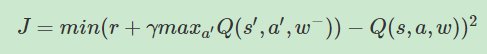

In [2]:
gameEnv = Game2048(4,"score")
RL = DQN(learning_rate=0.0005,sigma=1,grid_n = 4,batch_size=512,h1 = 256,input_type="emb",loss_type="mse",replace_update_fre=100,
         dqn_type = "double_dqn",
         net_type = "full_cnn_valid",
         data_rotate_expand = False,       
         loss_show_step=500,
         learning_rate_decay_rate=0.99,
                greedy_min=0.000001,
                memory_max_size=6000)
flag = False
for episode in range(200000):
    RL.episode += 1
    # 初始化环境
#     if episode > 1000:
#         gameEnv.reset(random.choice(RL.memory)[0])
#     else:
    gameEnv.reset()
    observation = copy.deepcopy(gameEnv.matrix)
    while True:
        # DQN 根据观测值选择行为
        if flag:
            l = ["a","w","s","d"]
            l.remove(action)
            action = random.choice(l)
        else:
            action = RL.get_action([observation],"train","action")   
        # 环境根据行为给出下一个 state, reward, 是否终止
        observation_, reward, done = gameEnv.step(action)
        # DQN 存储记忆
        RL.experience_store_expand(observation, action, reward,done,observation_)
        # 控制学习起始时间和频率 (先累积一些记忆再开始学习)
        RL.train()
        # 将下一个 state_ 变为 下次循环的 state
        flag = True if observation_ == observation else False
        observation = copy.deepcopy(observation_)
        # 如果终止, 就跳出循环
        RL.total_iters += 1
        if done:
            break
#     if  RL.episode > 300:
#         for i in range(10):
#             RL.train()
            
    if RL.episode % 1000 == 0 and RL.episode > 300:
        status1 = [[2, 4, 16, 2], [16, 64, 512, 8], [4, 2, 32, 2], [32, 4, 2, 4]]
        status2 = [[0,0,0,0],[0,0,0,0],[0,2,0,0],[4,0,0,4]]
        status3 = [[0,0,0,0],[0,0,0,0],[0,2,2,0],[4,0,0,4]]
        status4 = [[0,0,0,0],[0,0,0,0],[0,2,0,0],[0,2,0,0]]
        status5 = [[2, 4, 16, 2], [16, 64, 512, 8], [4, 2, 32, 2], [32, 4, 2, 0]]
        for status_i in [status1,status5,status2,status3,status4]:
            print RL.sess.run([RL.current_predictions], feed_dict={RL.matrixInput:np.array(np.array(([RL.transform_input(status_i)])))})[0]
        evaluate(gameEnv,RL)



Instructions for updating:
Use `argmax` instead
[[0.4713893  0.32668877 0.35458845 0.2723894 ]]
[[0.48264942 0.32460213 0.355231   0.26845053]]
[[0.2263311  0.15630989 0.18702531 0.1988984 ]]
[[0.22233297 0.18438217 0.25489715 0.20599213]]
[[0.21014419 0.12024566 0.21404716 0.14274946]]
--------------------------avg_top:83.040000 max_top:256 avg:754 max:2276 min:156 e:0.771071 episode:1000 memory_size:5603 lr:0.000500
[[0.42911863 0.5233428  0.4700046  0.28662214]]
[[0.4104781  0.50481856 0.45125306 0.3068171 ]]
[[0.21543382 0.37434316 0.39773777 0.2190137 ]]
[[0.35122946 0.44648215 0.3965399  0.3764785 ]]
[[0.1497495  0.38701975 0.40968335 0.13453376]]
--------------------------avg_top:111.360000 max_top:256 avg:1016 max:2520 min:164 e:0.654055 episode:2000 memory_size:5873 lr:0.000500
('loss', 500, 0.07250053)
[[0.31954664 0.80227333 0.68078524 0.38349217]]
[[0.28044495 0.8284178  0.659958   0.4059925 ]]
[[0.38290858 0.42995906 0.48150498 0.41502184]]
[[0.6493932  0.4759635  0.558962

--------------------------avg_top:219.200000 max_top:512 avg:2374 max:5028 min:272 e:0.000000 episode:22000 memory_size:5632 lr:0.000475
('loss', 6000, 2.2415843)
[[1.0312228 2.0880084 2.5221682 1.7261862]]
[[3.7147064 6.354312  5.0107126 6.4416246]]
[[32.176193 31.817732 32.01929  32.88509 ]]
[[32.512123 32.01638  32.055244 33.138577]]
[[32.02429  32.626415 32.115997 32.7536  ]]
--------------------------avg_top:222.720000 max_top:512 avg:2416 max:6376 min:528 e:0.000000 episode:23000 memory_size:5999 lr:0.000471
('loss', 6500, 2.838791)
[[-0.70727515 -0.20894471 -1.30021     0.9503993 ]]
[[2.0212183 6.0612    2.4925518 6.598871 ]]
[[29.545881 28.23625  29.48724  29.616148]]
[[29.732615 28.25893  29.410858 29.774984]]
[[28.840412 28.696844 29.013275 29.085749]]
--------------------------avg_top:194.560000 max_top:512 avg:1998 max:5736 min:244 e:0.000000 episode:24000 memory_size:5932 lr:0.000471
[[3.6201627 3.825568  4.844135  4.3716984]]
[[6.2420597 9.013343  7.5889    9.845555 ]]
[[

--------------------------avg_top:277.760000 max_top:512 avg:3050 max:6604 min:536 e:0.000000 episode:44000 memory_size:5505 lr:0.000439
[[0.50493103 2.1073596  0.9263772  2.0671668 ]]
[[3.0400925 9.518331  6.053887  9.103639 ]]
[[45.702183 45.103527 45.758797 45.942677]]
[[46.61501  44.89112  45.71033  46.202374]]
[[45.601265 45.784996 45.746773 45.93704 ]]
--------------------------avg_top:278.720000 max_top:1024 avg:3143 max:9316 min:376 e:0.000000 episode:45000 memory_size:5888 lr:0.000439
('loss', 14000, 2.941319)
[[2.4858458 4.3535457 3.7916384 2.9665737]]
[[ 5.4161797 12.206043   9.369048  11.498925 ]]
[[43.348606 43.240074 43.648315 43.760513]]
[[43.90762  43.597557 44.080364 44.281685]]
[[43.081814 43.85158  43.613743 43.821022]]
--------------------------avg_top:264.960000 max_top:512 avg:2860 max:6596 min:432 e:0.000000 episode:46000 memory_size:5827 lr:0.000434
('loss', 14500, 3.117948)
[[-0.09185214  1.9889928  -0.425531   -0.5033495 ]]
[[ 2.6135502 10.1782675  5.4815803  

[[2.126237  5.965907  4.9265337 1.3500701]]
[[ 4.7297444 14.029837  10.459196  11.664707 ]]
[[41.949154 41.22151  41.84247  41.78941 ]]
[[42.339787 41.224476 41.66826  41.759735]]
[[41.81638 41.44067 41.48991 41.61717]]
--------------------------avg_top:293.120000 max_top:1024 avg:3121 max:10328 min:556 e:0.000000 episode:66000 memory_size:5703 lr:0.000401
[[-2.74214   -1.1703348 -3.7006273 -4.239174 ]]
[[-0.46225882 10.142276    3.862378   10.0730095 ]]
[[46.321873 45.20292  45.5484   45.572098]]
[[47.08567  45.817593 46.091892 46.190117]]
[[45.97771  45.349403 45.185467 45.453854]]
--------------------------avg_top:317.440000 max_top:1024 avg:3601 max:11392 min:784 e:0.000000 episode:67000 memory_size:5578 lr:0.000401
('loss', 22500, 1.8464862)
[[-0.53581005  3.2140262   0.9562023   1.1268114 ]]
[[ 1.8724518 11.557924   7.2137923 10.857834 ]]
[[43.83099  43.70667  44.831997 44.253784]]
[[44.332474 43.93071  45.017487 44.72093 ]]
[[43.435364 43.810555 44.64164  44.184402]]
-----------

('loss', 32000, 3.524263)
[[ 4.2536016   6.1441145   1.6287915  -0.41638651]]
[[ 7.6442943 19.698795  12.619262  18.890274 ]]
[[55.22518  54.043888 55.3852   55.299667]]
[[55.879253 54.522057 55.846256 56.135483]]
[[54.741905 53.593437 54.94653  54.813103]]
--------------------------avg_top:393.600000 max_top:1024 avg:4586 max:11896 min:892 e:0.000000 episode:87000 memory_size:5610 lr:0.000362
('loss', 32500, 3.0623932)
[[ 2.9827464   2.7668529  -0.77099603 -0.26502538]]
[[ 6.2974224 17.1285    10.745115  15.96237  ]]
[[55.360996 55.498787 56.75849  55.77865 ]]
[[56.17975  55.982075 57.038795 56.591965]]
[[54.777702 55.2682   56.454544 55.526382]]
--------------------------avg_top:377.920000 max_top:1024 avg:4742 max:13460 min:380 e:0.000000 episode:88000 memory_size:5880 lr:0.000362
('loss', 33000, 3.3161209)
[[-0.37883848 -2.7954412  -8.616839   -7.4455867 ]]
[[ 3.36666  14.334915  5.240202 14.337286]]
[[60.726246 60.87399  61.96844  61.62812 ]]
[[61.765884 61.48139  62.655663 62.684

('loss', 44500, 4.43082)
[[-1.7524867 -2.1261907 -6.7617583 -8.87378  ]]
[[ 2.1428883 16.643667   9.6387825 22.421852 ]]
[[72.476555 72.40267  75.175285 74.6028  ]]
[[72.56449 73.24693 75.58755 76.22935]]
[[71.361885 71.25194  74.37301  73.92999 ]]
--------------------------avg_top:525.440000 max_top:1024 avg:6512 max:15612 min:708 e:0.000000 episode:108000 memory_size:5751 lr:0.000321
('loss', 45000, 6.005974)
[[4.4417477 5.4753337 4.5422525 3.1202307]]
[[ 9.51154  24.143637 21.839851 25.085695]]
[[74.54964 74.34325 75.16758 72.92274]]
[[74.9908  75.43409 75.66376 74.76481]]
[[73.50377  73.996376 74.76449  72.84493 ]]
--------------------------avg_top:590.080000 max_top:2048 avg:7161 max:20300 min:1308 e:0.000000 episode:109000 memory_size:5783 lr:0.000318
('loss', 45500, 5.8814034)
('loss', 46000, 7.657174)
[[ 4.639082  12.041123   6.4116507  9.440922 ]]
[[10.269421 27.482958 22.744938 26.505243]]
[[73.76975  73.86975  74.782974 72.873405]]
[[74.897255 75.07946  75.729965 75.15631 ]]

--------------------------avg_top:657.920000 max_top:2048 avg:8091 max:25380 min:588 e:0.000000 episode:128000 memory_size:5529 lr:0.000276
('loss', 59500, 5.8547654)
('loss', 60000, 3.9702468)
[[ 0.03299853  1.1960177  -0.9735733  -7.4436755 ]]
[[ 3.2485223 17.776482  14.57535   17.383087 ]]
[[88.017006 87.39293  90.36702  90.158066]]
[[89.40565  88.25973  91.901886 91.38204 ]]
[[86.83494  87.95045  90.06986  89.867256]]
--------------------------avg_top:627.200000 max_top:1024 avg:8022 max:17724 min:520 e:0.000000 episode:129000 memory_size:5669 lr:0.000274
('loss', 60500, 5.976025)
('loss', 61000, 6.7799463)
[[2.0049007 4.6969094 7.7762136 2.2642713]]
[[ 7.1042175 24.161259  21.221123  23.760433 ]]
[[91.15445 89.97014 93.80765 93.79686]]
[[92.64513  90.10616  95.169464 94.53185 ]]
[[89.76489  90.54277  93.112305 93.27183 ]]
--------------------------avg_top:641.920000 max_top:2048 avg:8129 max:25636 min:556 e:0.000000 episode:130000 memory_size:5690 lr:0.000271
('loss', 61500, 5.049

('loss', 76500, 7.9974804)
('loss', 77000, 10.688054)
[[ 5.559392  10.329595   9.695299   6.0103703]]
[[10.6170845 27.207645  22.22543   25.954165 ]]
[[107.37902  105.85704  109.234924 108.971146]]
[[109.20751  106.702705 111.06587  109.51069 ]]
[[105.83386  107.246445 108.542595 108.92749 ]]
--------------------------avg_top:725.760000 max_top:2048 avg:9070 max:27816 min:1252 e:0.000000 episode:149000 memory_size:5500 lr:0.000231
('loss', 77500, 7.9462156)
[[ 6.9932795   8.936305    4.661646   -0.56093055]]
[[11.399556 26.012882 21.036287 25.114002]]
[[108.79614 108.30665 112.53393 112.98193]]
[[110.08849  108.604645 114.47655  113.67067 ]]
[[107.58994  109.95877  112.078575 113.41601 ]]
--------------------------avg_top:766.080000 max_top:2048 avg:9708 max:25528 min:724 e:0.000000 episode:150000 memory_size:5701 lr:0.000231
('loss', 78000, 9.357459)
('loss', 78500, 8.846357)
[[5.70387   1.7748753 6.1380606 5.7810245]]
[[11.967519 21.539213 21.337965 25.169674]]
[[110.4022   106.92681

MemoryError: 

In [ ]:
res = np.array(random.sample(RL.memory, RL.batch_size)).tolist()

In [4]:
RL.memory.pop(len(RL.memory)-1)

[[[8, 0, 0, 0], [16, 0, 0, 2], [4, 4, 8, 0], [2, 16, 4, 0]],
 'd',
 0.3169925001442312,
 False,
 [[0, 0, 0, 8], [0, 0, 16, 2], [2, 0, 8, 8], [0, 2, 16, 4]]]

In [3]:
gameEnv.display(gameEnv.max_matrix)

32	 2048	 512	 1024	 

2	 64	 128	 256	 

8	 16	 32	 8	 

4	 2	 16	 4	 



In [6]:
evaluate(gameEnv,RL)

--------------------------avg_top:102.720000 max_top:256 avg:1006 max:2744 min:216 e:0.254187 episode:1657 memory_size:6753


In [9]:
RL.episode

1718

In [10]:
check_one_game_with_model(gameEnv,RL,True)

-	 -	 -	 -	 

2	 -	 -	 -	 

-	 -	 2	 -	 

-	 -	 -	 -	 

choose: d 129.96614
_________________________________________
-	 -	 -	 -	 

-	 -	 -	 2	 

-	 -	 -	 2	 

-	 -	 2	 -	 

choose: w 128.62384
_________________________________________
-	 -	 2	 4	 

2	 -	 -	 -	 

-	 -	 -	 -	 

-	 -	 -	 -	 

choose: s 127.99535
_________________________________________
-	 -	 -	 -	 

-	 -	 -	 -	 

-	 -	 -	 -	 

2	 2	 2	 4	 

choose: w 129.09157
_________________________________________
2	 2	 2	 4	 

-	 4	 -	 -	 

-	 -	 -	 -	 

-	 -	 -	 -	 

choose: a 127.94079
_________________________________________
2	 4	 4	 -	 

4	 -	 -	 -	 

-	 -	 -	 -	 

-	 -	 -	 4	 

choose: d 128.02039
_________________________________________
-	 -	 2	 8	 

-	 -	 -	 4	 

-	 2	 -	 -	 

-	 -	 -	 4	 

choose: a 127.62436
_________________________________________
2	 8	 -	 -	 

4	 4	 -	 -	 

2	 -	 -	 -	 

4	 -	 -	 -	 

choose: d 127.76847
_________________________________________
-	 -	 2	 8	 

-	 -	 -	 8	 

-	 -	 -	 2	 

4	 -	 -	 4	 



choose: w 115.04099
_________________________________________
8	 64	 128	 32	 

4	 8	 8	 16	 

16	 2	 -	 2	 

4	 -	 -	 -	 

choose: d 115.82503
_________________________________________
8	 64	 128	 32	 

-	 4	 16	 16	 

-	 -	 16	 4	 

2	 -	 -	 4	 

choose: w 114.383995
_________________________________________
8	 64	 128	 32	 

2	 4	 32	 16	 

-	 4	 -	 8	 

-	 -	 -	 -	 

choose: w 114.22993
_________________________________________
8	 64	 128	 32	 

2	 8	 32	 16	 

4	 -	 -	 8	 

-	 -	 -	 -	 

choose: d 114.52446
_________________________________________
8	 64	 128	 32	 

2	 8	 32	 16	 

-	 -	 4	 8	 

-	 -	 -	 2	 

choose: a 114.340996
_________________________________________
8	 64	 128	 32	 

2	 8	 32	 16	 

4	 8	 -	 -	 

2	 4	 -	 -	 

choose: w 114.1738
_________________________________________
8	 64	 128	 32	 

2	 16	 32	 16	 

4	 4	 -	 -	 

2	 4	 -	 -	 

choose: w 113.16585
_________________________________________
8	 64	 128	 32	 

2	 16	 32	 16	 

4	 8	 -	 4	 

2	 -	 -	 -	 

choo

choose: a 89.68916
_________________________________________
32	 8	 256	 4	 

4	 256	 -	 -	 

16	 4	 -	 -	 

4	 2	 4	 4	 

choose: d 90.07165
_________________________________________
32	 8	 256	 4	 

-	 -	 4	 256	 

-	 -	 16	 4	 

4	 4	 2	 8	 

choose: w 86.596405
_________________________________________
32	 8	 256	 4	 

4	 4	 4	 256	 

-	 -	 16	 4	 

-	 4	 2	 8	 

choose: a 88.14188
_________________________________________
32	 8	 256	 4	 

4	 8	 256	 -	 

16	 4	 2	 -	 

4	 2	 8	 -	 

choose: w 97.99758
_________________________________________
32	 16	 512	 4	 

4	 4	 2	 -	 

16	 2	 8	 -	 

4	 4	 -	 -	 

choose: d 89.92089
_________________________________________
32	 16	 512	 4	 

-	 2	 8	 2	 

-	 16	 2	 8	 

-	 -	 -	 8	 

choose: a 89.03117
_________________________________________
32	 16	 512	 4	 

2	 8	 2	 -	 

16	 2	 8	 -	 

8	 4	 -	 -	 

choose: d 86.86082
_________________________________________
32	 16	 512	 4	 

-	 2	 8	 2	 

-	 16	 2	 8	 

4	 -	 8	 4	 

choose: a 84.545654

-	 4	 32	 8	 

-	 2	 8	 16	 

2	 -	 2	 8	 

choose: a 94.818474
_________________________________________
16	 32	 256	 512	 

4	 32	 8	 2	 

2	 8	 16	 -	 

4	 8	 -	 -	 

choose: w 98.08325
_________________________________________
16	 64	 256	 512	 

4	 16	 8	 2	 

2	 -	 16	 4	 

4	 -	 -	 -	 

choose: a 97.24716
_________________________________________
16	 64	 256	 512	 

4	 16	 8	 2	 

2	 16	 4	 -	 

4	 2	 -	 -	 

choose: w 98.493706
_________________________________________
16	 64	 256	 512	 

4	 32	 8	 2	 

2	 2	 4	 -	 

4	 -	 4	 -	 

choose: w 96.66965
_________________________________________
16	 64	 256	 512	 

4	 32	 8	 2	 

2	 2	 8	 2	 

4	 -	 -	 -	 

choose: d 97.24327
_________________________________________
16	 64	 256	 512	 

4	 32	 8	 2	 

-	 4	 8	 2	 

-	 4	 -	 4	 

choose: w 98.90394
_________________________________________
16	 64	 256	 512	 

4	 32	 16	 4	 

-	 8	 -	 4	 

-	 2	 -	 -	 

choose: w 97.90993
_________________________________________
16	 64	 256	 512	 

4

choose: w 86.009476
_________________________________________
32	 128	 256	 512	 

2	 16	 32	 128	 

-	 2	 16	 8	 

-	 -	 2	 4	 

choose: a 83.49569
_________________________________________
32	 128	 256	 512	 

2	 16	 32	 128	 

2	 16	 8	 2	 

2	 4	 -	 -	 

choose: w 85.49633
_________________________________________
32	 128	 256	 512	 

2	 32	 32	 128	 

4	 4	 8	 2	 

-	 -	 4	 -	 

choose: d 83.39076
_________________________________________
32	 128	 256	 512	 

-	 2	 64	 128	 

-	 8	 8	 2	 

-	 2	 -	 4	 

choose: d 80.87439
_________________________________________
32	 128	 256	 512	 

-	 2	 64	 128	 

2	 -	 16	 2	 

-	 -	 2	 4	 

choose: w 81.874504
_________________________________________
32	 128	 256	 512	 

2	 2	 64	 128	 

-	 -	 16	 2	 

-	 2	 2	 4	 

choose: d 81.069275
_________________________________________
32	 128	 256	 512	 

2	 4	 64	 128	 

-	 -	 16	 2	 

-	 -	 4	 4	 

choose: a 80.317184
_________________________________________
32	 128	 256	 512	 

2	 4	 64	 128	 



choose: w 70.54477
_________________________________________
32	 128	 1024	 32	 

4	 32	 64	 8	 

-	 8	 2	 4	 

-	 -	 4	 2	 

choose: a 67.22239
_________________________________________
32	 128	 1024	 32	 

4	 32	 64	 8	 

8	 2	 4	 -	 

4	 2	 -	 2	 

choose: w 69.663445
_________________________________________
32	 128	 1024	 32	 

4	 32	 64	 8	 

8	 4	 4	 2	 

4	 -	 -	 4	 

choose: d 68.675865
_________________________________________
32	 128	 1024	 32	 

4	 32	 64	 8	 

4	 8	 8	 2	 

-	 -	 -	 8	 

choose: w 66.587425
_________________________________________
32	 128	 1024	 32	 

8	 32	 64	 8	 

-	 8	 8	 2	 

2	 -	 -	 8	 

choose: a 66.49172
_________________________________________
32	 128	 1024	 32	 

8	 32	 64	 8	 

16	 2	 4	 -	 

2	 8	 -	 -	 

choose: d 66.81635
_________________________________________
32	 128	 1024	 32	 

8	 32	 64	 8	 

-	 16	 2	 4	 

-	 2	 2	 8	 

choose: w 65.773506
_________________________________________
32	 128	 1024	 32	 

8	 32	 64	 8	 

-	 16	 4	 4	 


4	 -	 -	 2	 

choose: w 68.08016
_________________________________________
8	 16	 512	 1024	 

4	 2	 32	 2	 

-	 -	 8	 4	 

-	 -	 2	 2	 

choose: d 65.3668
_________________________________________
8	 16	 512	 1024	 

4	 2	 32	 2	 

4	 -	 8	 4	 

-	 -	 -	 4	 

choose: w 68.25839
_________________________________________
8	 16	 512	 1024	 

8	 2	 32	 2	 

-	 -	 8	 8	 

-	 -	 2	 -	 

choose: w 68.308304
_________________________________________
16	 16	 512	 1024	 

-	 2	 32	 2	 

-	 -	 8	 8	 

-	 -	 2	 4	 

choose: d 67.596146
_________________________________________
-	 32	 512	 1024	 

-	 2	 32	 2	 

-	 -	 -	 16	 

4	 -	 2	 4	 

choose: w 67.60948
_________________________________________
4	 32	 512	 1024	 

2	 2	 32	 2	 

-	 -	 2	 16	 

-	 -	 -	 4	 

choose: a 67.56531
_________________________________________
4	 32	 512	 1024	 

4	 32	 2	 -	 

2	 16	 -	 -	 

4	 -	 -	 4	 

choose: w 70.38586
_________________________________________
8	 64	 512	 1024	 

2	 16	 2	 4	 

4	 -	 -	 -	 

-	 

4	 64	 16	 2	 

-	 4	 8	 4	 

2	 -	 2	 8	 

choose: a 53.07761
_________________________________________
32	 128	 512	 1024	 

4	 64	 16	 2	 

4	 8	 4	 -	 

4	 8	 4	 -	 

choose: w 52.44914
_________________________________________
32	 128	 512	 1024	 

4	 64	 16	 2	 

8	 16	 8	 -	 

-	 -	 -	 4	 

choose: d 53.518703
_________________________________________
32	 128	 512	 1024	 

4	 64	 16	 2	 

-	 8	 16	 8	 

4	 -	 -	 4	 

choose: w 53.508926
_________________________________________
32	 128	 512	 1024	 

8	 64	 32	 2	 

4	 8	 -	 8	 

-	 -	 -	 4	 

choose: d 54.748028
_________________________________________
32	 128	 512	 1024	 

8	 64	 32	 2	 

-	 -	 4	 16	 

4	 -	 -	 4	 

choose: w 53.168877
_________________________________________
32	 128	 512	 1024	 

8	 64	 32	 2	 

4	 -	 4	 16	 

2	 -	 -	 4	 

choose: a 54.44226
_________________________________________
32	 128	 512	 1024	 

8	 64	 32	 2	 

8	 16	 4	 -	 

2	 4	 -	 -	 

choose: w 54.34921
_______________________________________

choose: s 29.687702
_________________________________________
2	 4	 256	 512	 

-	 16	 128	 1024	 

16	 8	 32	 16	 

2	 4	 8	 2	 

choose: w 32.262177
_________________________________________
2	 4	 256	 512	 

16	 16	 128	 1024	 

2	 8	 32	 16	 

4	 4	 8	 2	 

choose: d 34.157383
_________________________________________
2	 4	 256	 512	 

-	 32	 128	 1024	 

2	 8	 32	 16	 

2	 8	 8	 2	 

choose: w 30.217932
_________________________________________
2	 4	 256	 512	 

4	 32	 128	 1024	 

-	 16	 32	 16	 

-	 4	 8	 2	 

choose: a 27.737535
_________________________________________
2	 4	 256	 512	 

4	 32	 128	 1024	 

16	 32	 16	 4	 

4	 8	 2	 -	 

choose: w 32.880383
_________________________________________
2	 4	 256	 512	 

4	 64	 128	 1024	 

16	 8	 16	 4	 

4	 4	 2	 -	 

choose: d 38.699905
_________________________________________
2	 4	 256	 512	 

4	 64	 128	 1024	 

16	 8	 16	 4	 

-	 2	 8	 2	 

choose: a 33.573288
_________________________________________
2	 4	 256	 512	 

4	 64	

choose: w 85.99235
_________________________________________
16	 64	 2048	 8	 

-	 8	 16	 64	 

-	 -	 2	 8	 

-	 2	 -	 4	 

choose: w 85.26599
_________________________________________
16	 64	 2048	 8	 

-	 8	 16	 64	 

-	 2	 2	 8	 

4	 -	 -	 4	 

choose: d 84.28985
_________________________________________
16	 64	 2048	 8	 

-	 8	 16	 64	 

-	 -	 4	 8	 

-	 -	 4	 8	 

choose: w 84.84115
_________________________________________
16	 64	 2048	 8	 

-	 8	 16	 64	 

-	 -	 8	 16	 

-	 -	 -	 2	 

choose: a 84.815346
_________________________________________
16	 64	 2048	 8	 

8	 16	 64	 -	 

8	 16	 -	 4	 

2	 -	 -	 -	 

choose: d 87.10077
_________________________________________
16	 64	 2048	 8	 

-	 8	 16	 64	 

-	 8	 16	 4	 

-	 2	 -	 2	 

choose: w 84.314705
_________________________________________
16	 64	 2048	 8	 

-	 16	 32	 64	 

-	 2	 -	 4	 

-	 4	 -	 2	 

choose: a 83.082306
_________________________________________
16	 64	 2048	 8	 

16	 32	 64	 -	 

2	 4	 -	 2	 

4	 2	 -	 -	 



choose: w 63.907696
_________________________________________
32	 128	 2048	 32	 

8	 32	 128	 16	 

8	 8	 4	 -	 

2	 -	 -	 -	 

choose: w 63.518612
_________________________________________
32	 128	 2048	 32	 

16	 32	 128	 16	 

2	 8	 4	 -	 

-	 -	 -	 2	 

choose: d 62.716156
_________________________________________
32	 128	 2048	 32	 

16	 32	 128	 16	 

-	 2	 8	 4	 

-	 2	 -	 2	 

choose: a 61.94416
_________________________________________
32	 128	 2048	 32	 

16	 32	 128	 16	 

2	 8	 4	 -	 

4	 -	 2	 -	 

choose: d 61.583588
_________________________________________
32	 128	 2048	 32	 

16	 32	 128	 16	 

4	 2	 8	 4	 

-	 -	 4	 2	 

choose: a 60.218163
_________________________________________
32	 128	 2048	 32	 

16	 32	 128	 16	 

4	 2	 8	 4	 

4	 2	 -	 4	 

choose: w 60.318756
_________________________________________
32	 128	 2048	 32	 

16	 32	 128	 16	 

8	 4	 8	 8	 

-	 4	 -	 -	 

choose: w 59.982136
_________________________________________
32	 128	 2048	 32	 

16	 32	 1

choose: d 62.430878
_________________________________________
4	 2	 512	 2048	 

-	 32	 8	 4	 

-	 16	 4	 16	 

-	 2	 -	 4	 

choose: a 61.5078
_________________________________________
4	 2	 512	 2048	 

32	 8	 4	 -	 

16	 4	 16	 -	 

2	 4	 -	 2	 

choose: w 62.28119
_________________________________________
4	 2	 512	 2048	 

32	 8	 4	 2	 

16	 8	 16	 4	 

2	 -	 -	 -	 

choose: w 56.61596
_________________________________________
4	 2	 512	 2048	 

32	 16	 4	 2	 

16	 -	 16	 4	 

2	 -	 4	 -	 

choose: a 57.496
_________________________________________
4	 2	 512	 2048	 

32	 16	 4	 2	 

32	 4	 2	 -	 

2	 4	 -	 -	 

choose: w 60.335228
_________________________________________
4	 2	 512	 2048	 

64	 16	 4	 2	 

2	 8	 2	 -	 

-	 -	 -	 4	 

choose: d 57.946293
_________________________________________
4	 2	 512	 2048	 

64	 16	 4	 2	 

-	 2	 8	 2	 

-	 2	 -	 4	 

choose: w 59.835087
_________________________________________
4	 2	 512	 2048	 

64	 16	 4	 4	 

2	 4	 8	 4	 

-	 -	 -	 -	 

c

choose: w 48.838238
_________________________________________
32	 128	 512	 2048	 

8	 32	 128	 16	 

-	 2	 8	 8	 

-	 -	 -	 4	 

choose: a 47.614697
_________________________________________
32	 128	 512	 2048	 

8	 32	 128	 16	 

2	 16	 -	 4	 

4	 -	 -	 -	 

choose: d 47.275013
_________________________________________
32	 128	 512	 2048	 

8	 32	 128	 16	 

4	 2	 16	 4	 

-	 -	 -	 4	 

choose: w 46.206417
_________________________________________
32	 128	 512	 2048	 

8	 32	 128	 16	 

4	 2	 16	 8	 

-	 -	 -	 4	 

choose: a 45.90255
_________________________________________
32	 128	 512	 2048	 

8	 32	 128	 16	 

4	 2	 16	 8	 

4	 -	 -	 2	 

choose: w 45.904682
_________________________________________
32	 128	 512	 2048	 

8	 32	 128	 16	 

8	 2	 16	 8	 

4	 -	 -	 2	 

choose: w 44.523228
_________________________________________
32	 128	 512	 2048	 

16	 32	 128	 16	 

4	 2	 16	 8	 

-	 4	 -	 2	 

choose: a 41.52205
_________________________________________
32	 128	 512	 2048	 

1

choose: d 35.63961
_________________________________________
64	 256	 512	 2048	 

32	 128	 64	 8	 

2	 -	 8	 32	 

-	 -	 4	 4	 

choose: a 33.296497
_________________________________________
64	 256	 512	 2048	 

32	 128	 64	 8	 

2	 8	 32	 -	 

8	 -	 -	 4	 

choose: d 31.557058
_________________________________________
64	 256	 512	 2048	 

32	 128	 64	 8	 

-	 2	 8	 32	 

2	 -	 8	 4	 

choose: w 33.54612
_________________________________________
64	 256	 512	 2048	 

32	 128	 64	 8	 

2	 2	 16	 32	 

4	 -	 -	 4	 

choose: a 31.89581
_________________________________________
64	 256	 512	 2048	 

32	 128	 64	 8	 

4	 16	 32	 -	 

8	 4	 -	 -	 

choose: d 33.80437
_________________________________________
64	 256	 512	 2048	 

32	 128	 64	 8	 

4	 4	 16	 32	 

-	 -	 8	 4	 

choose: a 30.021389
_________________________________________
64	 256	 512	 2048	 

32	 128	 64	 8	 

8	 16	 32	 -	 

8	 4	 2	 -	 

choose: w 40.740486
_________________________________________
64	 256	 512	 2048	 


28840

In [15]:
print RL.get_action([observation]*100,"eval","sort_res")

[('s', 1036.5992), ('d', 652.64874), ('w', 229.1658), ('a', 29.73332)]


In [11]:
RL.sess.run(RL.learning_rate)

0.00011249552

In [7]:
import tensorflow as tf
saver = tf.train.Saver()

In [8]:
saver.save(RL.sess, "models/emb_cnn_16w_episode")

'models/emb_cnn_16w_episode'